In [1]:
ls

Loan Prediction Data Story.ipynb  accepted_2007_to_2018Q4.csv*


In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as pp

%matplotlib inline

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

import pymc3 as pm

from IPython import display
from ipywidgets import widgets, interact

In [3]:
import seaborn as sns
from matplotlib import rcParams
sns.set_style("whitegrid")
sns.set_context("poster")
pp.rcParams['figure.figsize'] = (7,7)

In [4]:
loan_data = pd.read_csv('accepted_2007_to_2018Q4.csv')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
loan_data.shape

(2260701, 151)

The dataset has 2.26 million rows and 151 features.

In [6]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


## Goal and Response Variable

Our goal is to predict if the loan applicant, when offered with a loan, will default in the future or not. We will be predicting this using the loan_status column, our response variable.

Let us look at the loan_status feature values and its counts.

In [7]:
loan_data['loan_status'].value_counts(dropna=False)
#dropna=False will display NaNs below

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
NaN                                                         33
Name: loan_status, dtype: int64

The model we build has to predict, for new data, if the loan_status will be Fully Paid or Charged Off. To train the model we only need loans that were fully paid or charged off so we can drop the other loan_status values.

In [8]:
loan_data = loan_data.loc[loan_data['loan_status'].isin(['Fully Paid', 'Charged Off'])]

In [9]:
loan_data.shape

(1345310, 151)

1.3 million rows remain in the data.

In [10]:
loan_data['loan_status'].value_counts()

Fully Paid     1076751
Charged Off     268559
Name: loan_status, dtype: int64

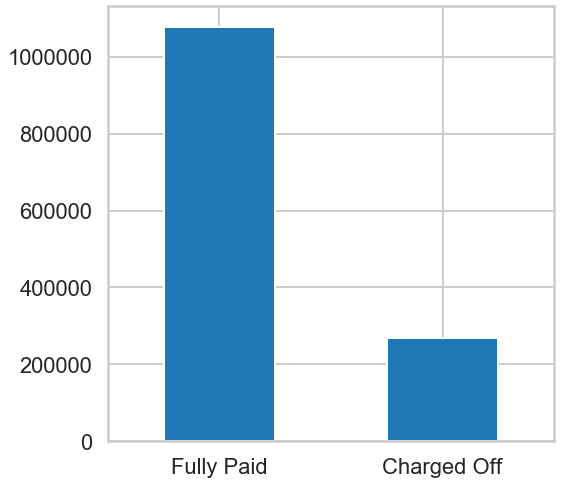

In [12]:
loan_data['loan_status'].value_counts().plot(kind='bar', rot=0)

Let's count these as percentages:

In [13]:
loan_data['loan_status'].value_counts(normalize=True)*100

Fully Paid     80.037389
Charged Off    19.962611
Name: loan_status, dtype: float64

About 80% of the loans were fully paid and 20% were charged off. 

## Data Cleaning and Feature Selection

**In the below step, features that have more than 40% of their data missing will be removed.**

In [14]:
cols_missing_values = loan_data.isna().sum()/len(loan_data)*100
print("Features with more than 40% missing values")
print(cols_missing_values[cols_missing_values > 40].sort_values(ascending=False))

Features with more than 40% missing values
member_id                                     100.000000
next_pymnt_d                                  100.000000
orig_projected_additional_accrued_interest     99.720585
hardship_length                                99.572292
hardship_type                                  99.572292
hardship_reason                                99.572292
hardship_status                                99.572292
deferral_term                                  99.572292
hardship_amount                                99.572292
hardship_start_date                            99.572292
hardship_end_date                              99.572292
payment_plan_start_date                        99.572292
hardship_dpd                                   99.572292
hardship_loan_status                           99.572292
hardship_payoff_balance_amount                 99.572292
hardship_last_payment_amount                   99.572292
sec_app_mths_since_last_major_derog          

In [15]:
percentage_missing_values = (loan_data.isna().sum()/len(loan_data)*100)

In [16]:
drop_features = percentage_missing_values[percentage_missing_values > 40].index

In [17]:
drop_features = list(drop_features)

In [18]:
len(drop_features)

58

In [19]:
loan_data.drop(columns = drop_features, axis=1, inplace=True)

In [20]:
loan_data.shape

(1345310, 93)

**Next we will drop the columns that will not be available in the applicant's application file.**

In [21]:
loan_data.columns

Index(['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'last_fico_range_high', 'last_fico_range_low',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'acc_open_past_24mths', 'a

Some features will be available to the investor when deciding to fund the loan or not, let's call these features as **known_features**.
Rest of the features - **unknown_features**

In [32]:
known_features = ['id', 'loan_amnt', 'term', 'int_rate','installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'loan_status', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'total_acc', 'initial_list_status', 
       'application_type', 'acc_now_delinq', 'mort_acc', 'pub_rec_bankruptcies']     

In [33]:
unknown_features = ['funded_amnt', 'funded_amnt_inv', 'issue_d', 'pymnt_plan', 'url', 'delinq_2yrs', 
                    'revol_bal', 'revol_util', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 
                    'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 
                    'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d', 
                    'collections_12_mths_ex_med', 'policy_code',  'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 
                    'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 
                    'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 
                    'mo_sin_rcnt_tl', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 
                    'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 
                    'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 
                    'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 
                    'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 
                    'total_il_high_credit_limit', 'hardship_flag', 'disbursement_method', 
                    'debt_settlement_flag', 'last_fico_range_high', 'last_fico_range_low']

In [34]:
print('Number of known features: ', len(known_features))
print('Number of unknown features: ', len(unknown_features))

Number of known features:  30
Number of unknown features:  63


We will now drop the unknown features.

In [36]:
loan_data.drop(columns = unknown_features, axis=1, inplace=True)

In [37]:
loan_data.shape

(1345310, 30)

Let's save this dataset to a new file: 

In [38]:
loan_data.to_csv("loan_data1.csv", index=False)

In [4]:
loan_data1 = pd.read_csv("loan_data1.csv")

In [5]:
loan_data1.shape

(1345310, 30)

## Exploratory Data Analysis

Let's explore each of the features individually now.

In [6]:
loan_data1.columns

Index(['id', 'loan_amnt', 'term', 'int_rate', 'installment', 'grade',
       'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'loan_status', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'earliest_cr_line', 'fico_range_low',
       'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'total_acc',
       'initial_list_status', 'application_type', 'acc_now_delinq', 'mort_acc',
       'pub_rec_bankruptcies'],
      dtype='object')

## 1. id

In [7]:
loan_data1['id'].head()

0    68407277
1    68355089
2    68341763
3    68476807
4    68426831
Name: id, dtype: int64

In [8]:
loan_data1['id'].unique()

array([68407277, 68355089, 68341763, ..., 89996426, 90006534, 88224441])

In [9]:
loan_data1['id'].describe()

count    1.345310e+06
mean     5.634499e+07
std      3.836114e+07
min      5.473400e+04
25%      2.002774e+07
50%      5.773466e+07
75%      8.454605e+07
max      1.456364e+08
Name: id, dtype: float64

We can drop 'id' feature as this doesn't really provide us any information for data modelling.

In [5]:
loan_data1.drop(columns = 'id', axis=1, inplace=True)

In [11]:
loan_data1.shape

(1345310, 29)

## 2. loan_amnt

In [12]:
loan_data1.loan_amnt.head()

0     3600.0
1    24700.0
2    20000.0
3    10400.0
4    11950.0
Name: loan_amnt, dtype: float64

In [13]:
loan_data1['loan_amnt'].describe()

count    1.345310e+06
mean     1.441997e+04
std      8.717051e+03
min      5.000000e+02
25%      8.000000e+03
50%      1.200000e+04
75%      2.000000e+04
max      4.000000e+04
Name: loan_amnt, dtype: float64

## Remove missing value table below

In [14]:
mv = loan_data1.isna().sum()/len(loan_data1)*100
mv

loan_amnt               0.000000
term                    0.000000
int_rate                0.000000
installment             0.000000
grade                   0.000000
sub_grade               0.000000
emp_title               6.376597
emp_length              5.835904
home_ownership          0.000000
annual_inc              0.000000
verification_status     0.000000
loan_status             0.000000
purpose                 0.000000
title                   1.238302
zip_code                0.000074
addr_state              0.000000
dti                     0.027800
earliest_cr_line        0.000000
fico_range_low          0.000000
fico_range_high         0.000000
inq_last_6mths          0.000074
open_acc                0.000000
pub_rec                 0.000000
total_acc               0.000000
initial_list_status     0.000000
application_type        0.000000
acc_now_delinq          0.000000
mort_acc                3.514506
pub_rec_bankruptcies    0.051810
dtype: float64

## **plot loan amount continuous plot
## plot loan amount for fully paid vs. charged off loans**

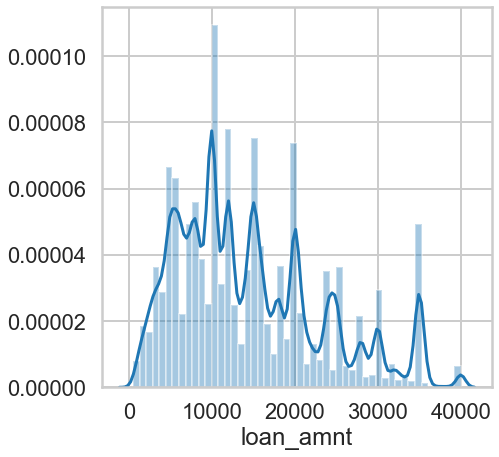

In [15]:
sns.distplot(loan_data1['loan_amnt'], norm_hist=True)

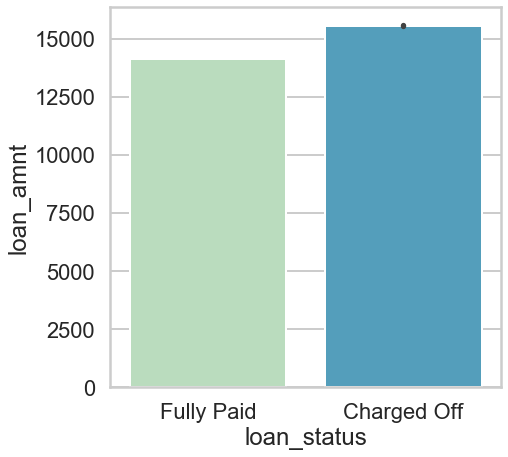

In [16]:
sns.barplot(x=loan_data1['loan_status'], y=loan_data1['loan_amnt'], palette='GnBu')

In [17]:
loan_data1['loan_amnt'].groupby(loan_data1['loan_status']).describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,268559.0,15565.055444,8814.560077,900.0,9000.0,14350.0,20400.0,40000.0
Fully Paid,1076751.0,14134.369808,8669.028973,500.0,7500.0,12000.0,20000.0,40000.0


From the above bar plot and the summary statistics table we see that **loans that were charged off have higher loan amounts** We see the same in the below box plot as well.

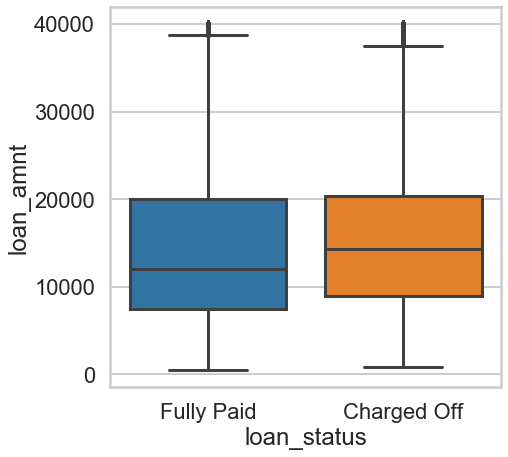

In [18]:
sns.boxplot(x=loan_data1['loan_status'], y=loan_data1['loan_amnt'])

## 3. term

In [19]:
loan_data1.term.head()

0     36 months
1     36 months
2     60 months
3     60 months
4     36 months
Name: term, dtype: object

In [20]:
loan_data1.term.unique()

array([' 36 months', ' 60 months'], dtype=object)

In [21]:
loan_data1.term.value_counts(dropna=False)

 36 months    1020743
 60 months     324567
Name: term, dtype: int64

**There are 2 loan terms lending club is offering - 36 months and 60 months.**

how many loans were charged off vs. fully paid for each of the terms? - stacked bar chart?

In [40]:
temp1 = loan_data1[['term', 'loan_status']]
#temp1.head()

In [27]:
temp1['value']=1

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [41]:
#temp1.head()

In [29]:
pivot_temp1 = pd.pivot_table(temp1, values='value', index='term', columns='loan_status', aggfunc=np.sum)

In [30]:
pivot_temp1

loan_status,Charged Off,Fully Paid
term,,
36 months,163252,857491
60 months,105307,219260


Text(0.5, 0, 'Term')

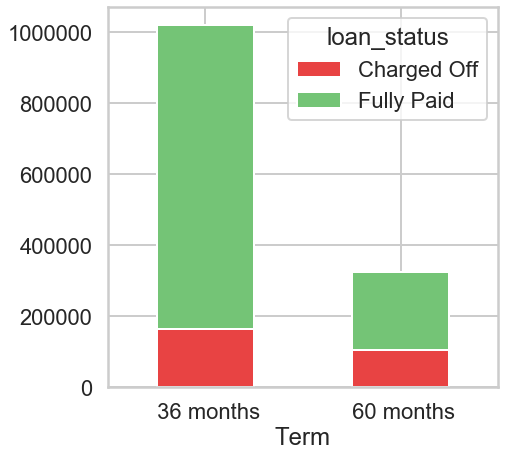

In [65]:
colors = ["#e84343","#74C476"]

pivot_temp1.plot.bar(stacked=True, color=colors)

pp.xticks(rotation=0)
pp.xlabel("Term")

In [44]:
temp1.groupby('term')['loan_status'].value_counts(normalize=True).loc[:'Charged Off']

term        loan_status
 36 months  Fully Paid     0.840066
            Charged Off    0.159934
 60 months  Fully Paid     0.675546
            Charged Off    0.324454
Name: loan_status, dtype: float64

For 36 months term loans, 84% were fully paid and 16% were charged off. 
For 60 months term loans, 68% were fully paid and 32% were charged off.

## 4. int_rate

In [45]:
loan_data1['int_rate'].head()

0    13.99
1    11.99
2    10.78
3    22.45
4    13.44
Name: int_rate, dtype: float64

In [47]:
loan_data1['int_rate'].describe()

count    1.345310e+06
mean     1.323962e+01
std      4.768716e+00
min      5.310000e+00
25%      9.750000e+00
50%      1.274000e+01
75%      1.599000e+01
max      3.099000e+01
Name: int_rate, dtype: float64

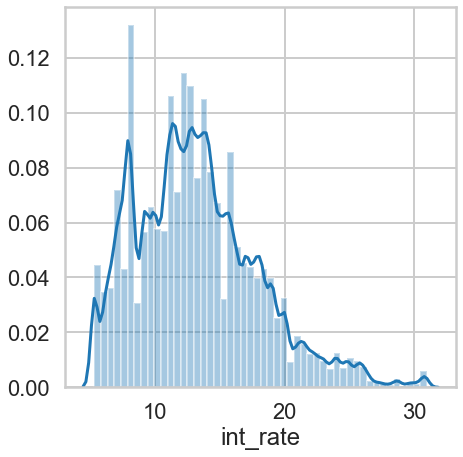

In [49]:
sns.distplot(loan_data1['int_rate'], norm_hist=True)

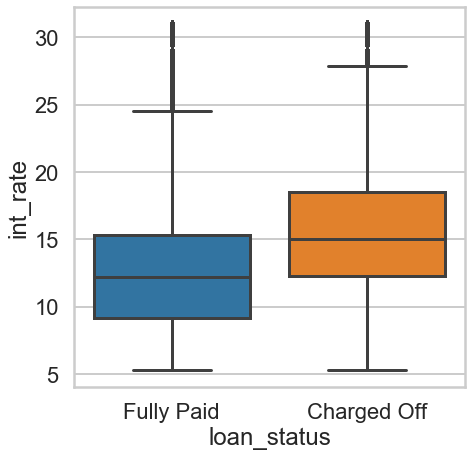

In [50]:
sns.boxplot(x=loan_data1['loan_status'], y=loan_data1['int_rate'])

In [51]:
loan_data1['int_rate'].groupby(loan_data1['loan_status']).describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,268559.0,15.710714,4.910387,5.31,12.29,15.05,18.55,30.99
Fully Paid,1076751.0,12.623288,4.527227,5.31,9.17,12.23,15.31,30.99


**Charged off loans have higher interest rates than fully paid loans.**

## 5. installment

In [52]:
loan_data1.installment.head()

0    123.03
1    820.28
2    432.66
3    289.91
4    405.18
Name: installment, dtype: float64

In [55]:
loan_data1.installment.describe()

count    1.345310e+06
mean     4.380755e+02
std      2.615126e+02
min      4.930000e+00
25%      2.484800e+02
50%      3.754300e+02
75%      5.807300e+02
max      1.719830e+03
Name: installment, dtype: float64

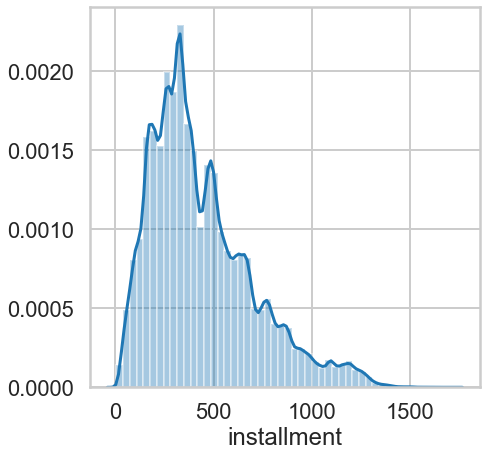

In [56]:
sns.distplot(loan_data1['installment'], norm_hist=True)

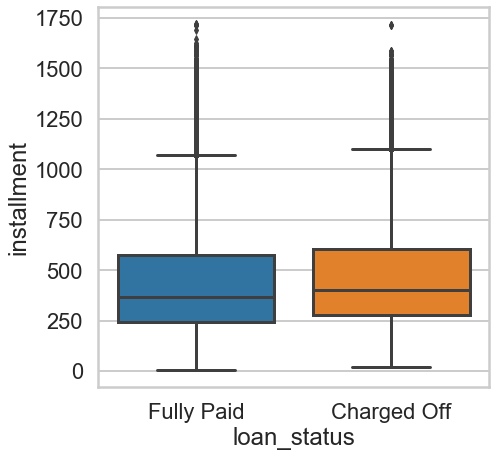

In [57]:
sns.boxplot(x=loan_data1['loan_status'], y=loan_data1['installment'])

In [58]:
loan_data1['installment'].groupby(loan_data1['loan_status']).describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,268559.0,465.147994,262.774106,21.62,275.29,402.83,605.31,1717.63
Fully Paid,1076751.0,431.323226,260.759563,4.93,240.92,368.26,573.06,1719.83


**Charged off loans have slightly higher installments**

## 6. grade

In [60]:
loan_data1.grade.unique()

array(['C', 'B', 'F', 'A', 'E', 'D', 'G'], dtype=object)

In [6]:
loan_data1.grade.value_counts(dropna=False)

B    392741
C    381686
A    235090
D    200953
E     93650
F     32058
G      9132
Name: grade, dtype: int64

## 7. sub-grade

In [68]:
loan_data1.sub_grade.unique()

array(['C4', 'C1', 'B4', 'F1', 'C3', 'B2', 'B1', 'A2', 'B5', 'C2', 'E2',
       'A4', 'E3', 'C5', 'A1', 'D4', 'F3', 'D1', 'B3', 'D3', 'D5', 'A5',
       'F2', 'E4', 'D2', 'E1', 'F5', 'E5', 'A3', 'G2', 'G1', 'G3', 'G4',
       'F4', 'G5'], dtype=object)

In [69]:
loan_data1.sub_grade.value_counts()

C1    85494
B4    83199
B5    82538
B3    81827
C2    79213
C3    74998
C4    74421
B2    74024
B1    71153
C5    67560
A5    64003
A4    52235
D1    51321
D2    44848
A1    43678
D3    39317
A3    37996
A2    37178
D4    35566
D5    29901
E1    23749
E2    21377
E3    18387
E4    15720
E5    14417
F1     9970
F2     7198
F3     6088
F4     4859
F5     3943
G1     2997
G2     2131
G3     1614
G4     1280
G5     1110
Name: sub_grade, dtype: int64

In [71]:
loan_data1[['grade', 'sub_grade']]

,grade,sub_grade
0,C,C4
1,C,C1
2,B,B4
3,F,F1
4,C,C3
...,...,...
1345305,B,B2
1345306,C,C3
1345307,C,C4
1345308,C,C1


**Grades are divided into sub-grades. We can drop grade and retain sub_grade.**

In [72]:
 loan_data1.drop(columns = 'grade', axis=1, inplace=True)

In [73]:
https://www.lendingclub.com/foliofn/rateDetail.action

SyntaxError: invalid syntax (<ipython-input-73-e554a32f9078>, line 1)

## 8. emp_title

In [74]:
loan_data1.emp_title.head()

0                 leadman
1                Engineer
2            truck driver
3     Contract Specialist
4    Veterinary Tecnician
Name: emp_title, dtype: object

In [7]:
loan_data1.emp_title.value_counts(dropna=False)

NaN                                         85785
Teacher                                     21268
Manager                                     19470
Owner                                       10302
Registered Nurse                             8774
                                            ...  
Senior Analyst / Project Lead                   1
Consultant. Architect continuous improve        1
Intramural Director                             1
Property Management Associate                   1
Commercial Relationship Officer                 1
Name: emp_title, Length: 378354, dtype: int64

Let's replace NaN with "Unknown".

In [9]:
loan_data1.emp_title.fillna(value="Unknown", inplace=True)

In [10]:
loan_data1.emp_title.value_counts(dropna=False)

Unknown                             85785
Teacher                             21268
Manager                             19470
Owner                               10302
Registered Nurse                     8774
                                    ...  
All Coast, LLC                          1
Indiana Market Manager                  1
Staffing & Scheduling                   1
Assistant Store Manager of Sales        1
Forensic Underweriter                   1
Name: emp_title, Length: 378354, dtype: int64

In [63]:
loan_data1.emp_title.describe()

count     1345310
unique     378354
top       Unknown
freq        85785
Name: emp_title, dtype: object

## what to do with grade, sub-grade and emp_title?

## 9. home_ownership

In [11]:
loan_data1.home_ownership.head()

0    MORTGAGE
1    MORTGAGE
2    MORTGAGE
3    MORTGAGE
4        RENT
Name: home_ownership, dtype: object

In [12]:
loan_data1.home_ownership.value_counts(dropna=False)

MORTGAGE    665579
RENT        534421
OWN         144832
ANY            286
OTHER          144
NONE            48
Name: home_ownership, dtype: int64

**Any and None values do not provide any specific information so we can replace it with None.**

In [13]:
loan_data1.home_ownership.replace(['ANY', 'NONE'], 'OTHER', inplace=True)

In [14]:
loan_data1.home_ownership.value_counts(dropna=False)

MORTGAGE    665579
RENT        534421
OWN         144832
OTHER          478
Name: home_ownership, dtype: int64

In [18]:
loan_data1.groupby('home_ownership')['loan_status'].value_counts()

home_ownership  loan_status
MORTGAGE        Fully Paid     551048
                Charged Off    114531
OTHER           Fully Paid        388
                Charged Off        90
OWN             Fully Paid     114968
                Charged Off     29864
RENT            Fully Paid     410347
                Charged Off    124074
Name: loan_status, dtype: int64

In [17]:
loan_data1.groupby('home_ownership')['loan_status'].value_counts().loc[:, 'Charged Off']

home_ownership
MORTGAGE    114531
OTHER           90
OWN          29864
RENT        124074
Name: loan_status, dtype: int64

In [20]:
temp2 = loan_data1[['home_ownership', 'loan_status']]

In [21]:
temp2['value2']=1

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [19]:
loan_data1.groupby('home_ownership')['loan_status'].value_counts().loc[:,:]

home_ownership  loan_status
MORTGAGE        Fully Paid     551048
                Charged Off    114531
OTHER           Fully Paid        388
                Charged Off        90
OWN             Fully Paid     114968
                Charged Off     29864
RENT            Fully Paid     410347
                Charged Off    124074
Name: loan_status, dtype: int64

In [22]:
pivot_temp2 = pd.pivot_table(temp2, values='value2', index='home_ownership', columns='loan_status', aggfunc=np.sum)

In [23]:
pivot_temp2

loan_status,Charged Off,Fully Paid
home_ownership,,
MORTGAGE,114531,551048
OTHER,90,388
OWN,29864,114968
RENT,124074,410347


Text(0.5, 0, 'Home Ownership')

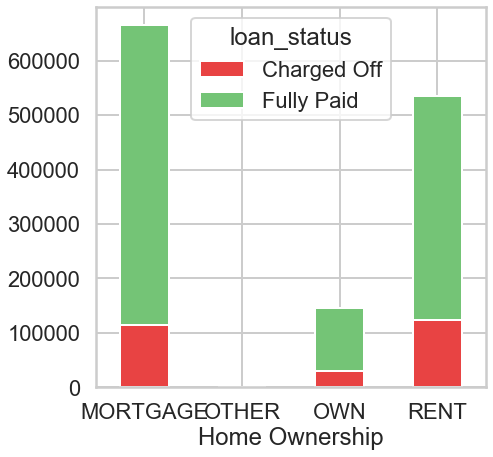

In [25]:
colors = ["#e84343","#74C476"]
pivot_temp2.plot.bar(stacked=True, color=colors)

pp.xticks(rotation=0)
pp.xlabel("Home Ownership")

**Renters and mortgage holders have better charge off rate than owners.**

Charge off rate by home ownership

In [26]:
loan_data1.groupby('home_ownership')['loan_status'].value_counts(normalize=True).loc[:, 'Charged Off']

home_ownership
MORTGAGE    0.172077
OTHER       0.188285
OWN         0.206198
RENT        0.232165
Name: loan_status, dtype: float64

**Home owners and renters have better charge off rates.**

## 10. annual_inc - ??

In [27]:
loan_data1.annual_inc.describe()

count    1.345310e+06
mean     7.624764e+04
std      6.992510e+04
min      0.000000e+00
25%      4.578000e+04
50%      6.500000e+04
75%      9.000000e+04
max      1.099920e+07
Name: annual_inc, dtype: float64

In [33]:
log_annual_inc = np.log(loan_data1['annual_inc'])

OverflowError: cannot convert float infinity to integer

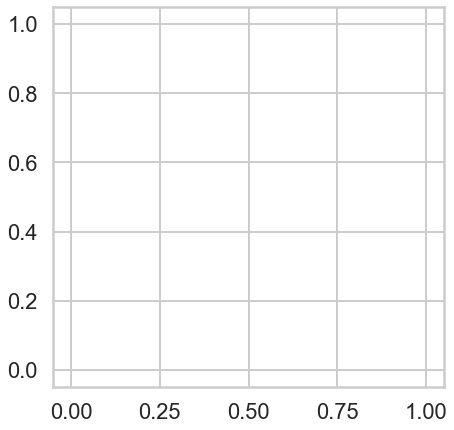

In [35]:
sns.distplot(log_annual_inc)

## 11. verification_status

In [42]:
loan_data1.verification_status.value_counts(dropna=False)

Source Verified    521273
Verified           418336
Not Verified       405701
Name: verification_status, dtype: int64

In [43]:
loan_data1.groupby('verification_status')['loan_status'].value_counts()

verification_status  loan_status
Not Verified         Fully Paid     346166
                     Charged Off     59535
Source Verified      Fully Paid     412041
                     Charged Off    109232
Verified             Fully Paid     318544
                     Charged Off     99792
Name: loan_status, dtype: int64

In [44]:
loan_data1.groupby('verification_status')['loan_status'].value_counts(normalize=True)

verification_status  loan_status
Not Verified         Fully Paid     0.853254
                     Charged Off    0.146746
Source Verified      Fully Paid     0.790451
                     Charged Off    0.209549
Verified             Fully Paid     0.761455
                     Charged Off    0.238545
Name: loan_status, dtype: float64

**<font color=red>
    Expected to see a smaller number for loans that were not verified but fully paid?**

## 12. purpose

In [46]:
loan_data1.purpose.value_counts()

debt_consolidation    780321
credit_card           295279
home_improvement       87504
other                  77875
major_purchase         29425
medical                15554
small_business         15416
car                    14585
moving                  9480
vacation                9065
house                   7253
wedding                 2294
renewable_energy         933
educational              326
Name: purpose, dtype: int64

In [47]:
loan_data1.purpose.value_counts(normalize=True)

debt_consolidation    0.580031
credit_card           0.219488
home_improvement      0.065044
other                 0.057886
major_purchase        0.021872
medical               0.011562
small_business        0.011459
car                   0.010841
moving                0.007047
vacation              0.006738
house                 0.005391
wedding               0.001705
renewable_energy      0.000694
educational           0.000242
Name: purpose, dtype: float64

Most loans (58%) were applied for debt consolidation.

In [49]:
loan_data1.groupby('purpose')['loan_status'].value_counts(normalize=True).loc[:, 'Charged Off'].sort_values()

purpose
wedding               0.121622
car                   0.146795
credit_card           0.169270
educational           0.171779
home_improvement      0.177158
major_purchase        0.185998
vacation              0.191726
other                 0.210401
debt_consolidation    0.211469
medical               0.217757
house                 0.218806
moving                0.233544
renewable_energy      0.236870
small_business        0.297094
Name: loan_status, dtype: float64

**Only 12.16% of loans for weddings were charged off, where as the charge off rate for loans for small businesses was 30%**

## 13. title

In [50]:
loan_data1.title.value_counts()

Debt consolidation                 660960
Credit card refinancing            249910
Home improvement                    75073
Other                               66778
Major purchase                      24045
                                    ...  
A fresher start                         1
stay strong                             1
Early Spring Financial Cleaning         1
Ccrefi                                  1
Solar Water Conversion                  1
Name: title, Length: 61682, dtype: int64

We will drop this feature as we have the "purpose" feature for this information

In [51]:
loan_data1.drop('title', axis=1, inplace=True)

## 14. zip_code

In [52]:
loan_data1.zip_code.head()

0    190xx
1    577xx
2    605xx
3    174xx
4    300xx
Name: zip_code, dtype: object

**The last 2 digits are not known so we drop this feature.**

In [53]:
loan_data1.drop('zip_code', axis=1, inplace=True)

In [55]:
loan_data1.shape

(1345310, 27)

## 15. addr_state

In [56]:
loan_data1.addr_state.head()

0    PA
1    SD
2    IL
3    PA
4    GA
Name: addr_state, dtype: object

In [57]:
loan_data1.addr_state.describe()

count     1345310
unique         51
top            CA
freq       196528
Name: addr_state, dtype: object

In [58]:
loan_data1.groupby('addr_state')['loan_status'].value_counts(normalize=True).loc[:, 'Charged Off'].sort_values()

addr_state
DC    0.132086
ME    0.138424
VT    0.139517
IA    0.142857
OR    0.143850
NH    0.145759
WV    0.155187
CO    0.155269
WA    0.157565
SC    0.162769
KS    0.167438
WY    0.167693
MT    0.168716
UT    0.170586
CT    0.173763
RI    0.178675
IL    0.180974
WI    0.183510
GA    0.183927
ID    0.188277
MA    0.190528
CA    0.196104
AZ    0.196299
AK    0.196552
MN    0.197430
DE    0.197462
TX    0.198223
VA    0.199422
HI    0.202013
MI    0.202957
ND    0.204744
OH    0.205283
NC    0.207839
PA    0.207921
KY    0.209829
NJ    0.211212
MO    0.212935
MD    0.213085
SD    0.213227
NM    0.213665
TN    0.214079
IN    0.214082
FL    0.214746
NV    0.219223
NY    0.220435
LA    0.231821
OK    0.234753
AL    0.236321
AR    0.240868
NE    0.251813
MS    0.260777
Name: loan_status, dtype: float64

**Charge off rate varies from 13% in District of Columbia to 26% in Mississippi**

## 16. dti

In [60]:
loan_data1.dti.head()

0     5.91
1    16.06
2    10.78
3    25.37
4    10.20
Name: dti, dtype: float64

In [62]:
loan_data1['dti'].describe()

count    1.344936e+06
mean     1.828267e+01
std      1.116045e+01
min     -1.000000e+00
25%      1.179000e+01
50%      1.761000e+01
75%      2.406000e+01
max      9.990000e+02
Name: dti, dtype: float64

<font color=red>
-1 and 999? 

In [66]:
loan_data1.dti.isnull().sum()

374

## 17. earliest_cr_line

In [64]:
loan_data1.earliest_cr_line.head()

0    Aug-2003
1    Dec-1999
2    Aug-2000
3    Jun-1998
4    Oct-1987
Name: earliest_cr_line, dtype: object

In [65]:
loan_data1.earliest_cr_line.describe()

count      1345310
unique         739
top       Aug-2001
freq          9391
Name: earliest_cr_line, dtype: object

In [67]:
loan_data1.earliest_cr_line.isnull().sum()

0

## 18. fico_range_low, fico_range_high

## 19. inq_last_6mths

## 20. open_acc

## 21. pub_rec

## 22. total_acc

## 23. initial_list_status

## 24. application_type

## 25. acc_now_delinq

In [97]:
loan_data1.acc_now_delinq.value_counts()

0.0     1338972
1.0        5975
2.0         306
3.0          42
4.0          10
5.0           3
14.0          1
6.0           1
Name: acc_now_delinq, dtype: int64

## 26. mort_acc

In [90]:
loan_data1.mort_acc.head()

0    1.0
1    4.0
2    5.0
3    6.0
4    0.0
Name: mort_acc, dtype: float64

In [91]:
loan_data1.mort_acc.describe()

count    1.298029e+06
mean     1.670783e+00
std      2.000444e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      3.000000e+00
max      5.100000e+01
Name: mort_acc, dtype: float64

In [92]:
loan_data1.groupby('loan_status')['mort_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,261673.0,1.371032,1.825505,0.0,0.0,1.0,2.0,29.0
Fully Paid,1036356.0,1.746468,2.035279,0.0,0.0,1.0,3.0,51.0


**The loans that were fully paid tend to have higher number of mortgage accounts**

## 27. pub_rec_bankruptcies

Number of public record bankruptcies

In [72]:
loan_data1.pub_rec_bankruptcies.value_counts(dropna=False)

0.0     1176953
1.0      157696
2.0        7769
3.0        1583
NaN         697
4.0         396
5.0         141
6.0          46
7.0          15
8.0           9
9.0           3
12.0          1
11.0          1
Name: pub_rec_bankruptcies, dtype: int64

Replacing NaNs with 0

In [73]:
loan_data1.pub_rec_bankruptcies.fillna(value=0.0, inplace=True)

In [94]:
loan_data1.pub_rec_bankruptcies.value_counts(dropna=False)

0.0     1177650
1.0      157696
2.0        7769
3.0        1583
4.0         396
5.0         141
6.0          46
7.0          15
8.0           9
9.0           3
12.0          1
11.0          1
Name: pub_rec_bankruptcies, dtype: int64

In [93]:
loan_data1.groupby('loan_status')['pub_rec_bankruptcies'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,268559.0,0.153527,0.40447,0.0,0.0,0.0,0.0,11.0
Fully Paid,1076751.0,0.129597,0.37075,0.0,0.0,0.0,0.0,12.0


**Fully paid loans have a slightly lower number of public record bankruptcies**

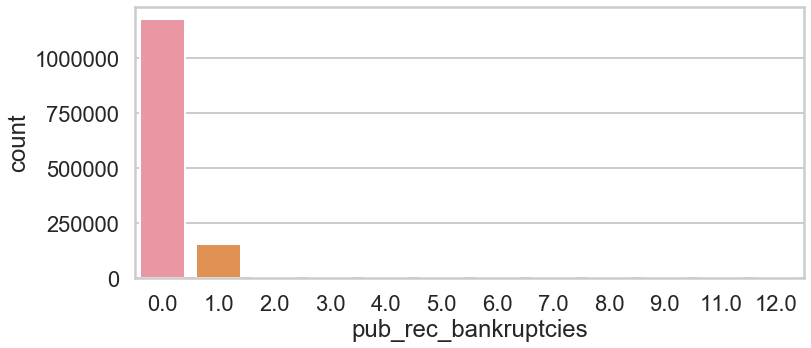

In [84]:
sns.countplot(x=loan_data1['pub_rec_bankruptcies'], data=loan_data1)
pp.rcParams['figure.figsize'] = (7,7)

In [88]:
loan_data1.groupby('pub_rec_bankruptcies')['loan_status'].value_counts().loc[:,'Charged Off']

pub_rec_bankruptcies
0.0     230582
1.0      35524
2.0       1926
3.0        358
4.0        110
5.0         33
6.0         16
7.0          4
8.0          4
9.0          1
11.0         1
Name: loan_status, dtype: int64

In [89]:
loan_data1.groupby('pub_rec_bankruptcies')['loan_status'].value_counts().loc[:,:]

pub_rec_bankruptcies  loan_status
0.0                   Fully Paid     947068
                      Charged Off    230582
1.0                   Fully Paid     122172
                      Charged Off     35524
2.0                   Fully Paid       5843
                      Charged Off      1926
3.0                   Fully Paid       1225
                      Charged Off       358
4.0                   Fully Paid        286
                      Charged Off       110
5.0                   Fully Paid        108
                      Charged Off        33
6.0                   Fully Paid         30
                      Charged Off        16
7.0                   Fully Paid         11
                      Charged Off         4
8.0                   Fully Paid          5
                      Charged Off         4
9.0                   Fully Paid          2
                      Charged Off         1
11.0                  Charged Off         1
12.0                  Fully Paid          